In [16]:
import matplotlib.image as mpimg
from PIL import Image
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [1]:
from somefunctions import *
from f1_score import *

# Model parameters
pool_size = (2, 2)
train_shape = 400 #size of the training images
patch_size = 16
input_size = 64
pad_size = int(input_size/2 - patch_size/2)


# Training parameters
reg = 1e-5  #regularization term
learning_rate = 0.001
nb_epoch = 45 #very small, only preliminary tests
batch_size = 256
steps_per_epoch = 125 #the number of training samples is huge, arbitrary value


# Data augmentation parameters
FLIP_FLAG = True # add random flips to the patches
ROTATION_FLAG = True # add random rotation to the patches
BRIGHT_CONTRAST_FLAG = True # modify randomly the brightness and the constrast


#Other stuff
NameWeights = 'NicolaWeights'
SubmissionName = 'NicolaSubmission.csv'

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [114]:
#load images and pad them
test_images = np.asarray(pick_test_images())

test_images = padding_imgs(np.array(test_images),pad_size)

test_images_not_padded = np.asarray(pick_test_images())

In [115]:
import pickle
name = 'prediction.pkl'
# Getting back the objects:
with open(name, 'rb') as f: 
    test_predicted_1D = pickle.load(f)
print('Recovered!')
test_labels = test_predicted_1D.reshape(50,-1)
print(test_labels.shape)

Recovered!
(50, 1444)


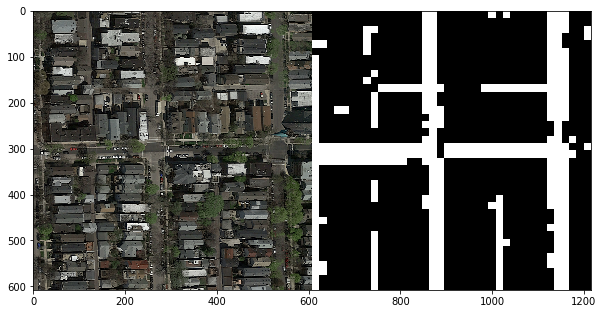

In [123]:
#check the prediction on the image IDX
IDX = 20
im = label_to_img(608, 608, 16, 16, test_labels[IDX])
plt.figure(figsize=[10,20])
plt.imshow(concatenate_images(test_images_not_padded[IDX], im))

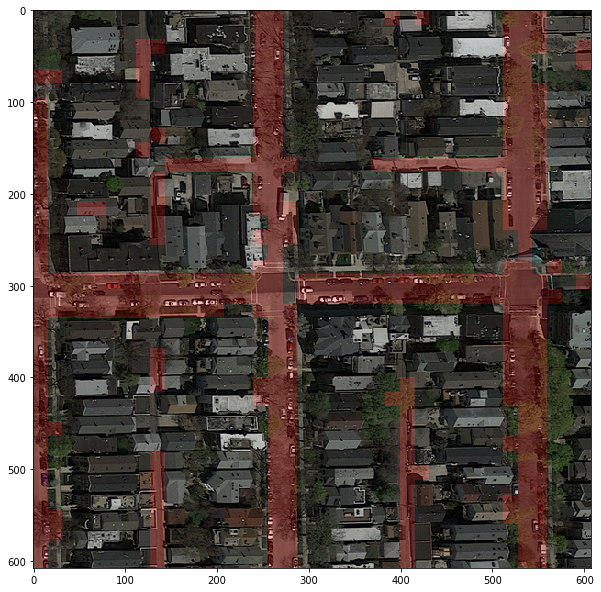

In [124]:
new_img = make_img_overlay(test_images_not_padded[IDX], im)

plt.figure(figsize=[10,20])
plt.imshow(new_img)
plt.savefig('pred.jpg', format='jpg')

In [125]:
def post_process_single(predicted_image,nbr_patches):

    for row in range(1,nbr_patches-1):
        for col in range (1,nbr_patches-1): 

            # Looking at the label of my_patch's neighbors
            nghb_left = predicted_image[col,row-1];
            nghb_right = predicted_image[col,row+1];
            nghb_up = predicted_image[col-1,row];
            nghb_down = predicted_image[col+1,row];
            nghb_up_left = predicted_image[col-1,row-1];
            nghb_up_right = predicted_image[col-1,row+1];
            nghb_down_left = predicted_image[col+1,row-1];
            nghb_down_right = predicted_image[col+1,row+1];

            # There are 8 neighbors for patches not on the border
            neighbors = np.array([nghb_left,nghb_right,nghb_up,nghb_down,nghb_up_left,nghb_up_right,nghb_down_left,nghb_down_right])

            nbr_labels_street_nghb = np.sum(neighbors)
            nbr_labels_background_nghb = 8-np.sum(neighbors)


            is_horizontal_street = (nghb_left == nghb_right == 1)
            is_vertical_street = (nghb_up == nghb_down ==1 )

            is_street = (is_horizontal_street or is_vertical_street)

            # If a black patch is sourrounded by many white patches it becomes white
            if (nbr_labels_street_nghb >= 5 or is_street):
                predicted_image[col,row] = 1

            # If a white patch is sourrounded by many black patches it becomes black  
            if (nbr_labels_background_nghb >= 6 and not(is_street)):
                predicted_image[col,row] = 0
                
    return predicted_image


In [126]:
patches_38x38 = test_labels[IDX].reshape(38,38)

In [127]:
post_processed_patches1 = post_process_single(patches_38x38,38)
post_processed_image1 = label_to_img(608, 608, 16, 16, post_processed_patches1.reshape(38*38))

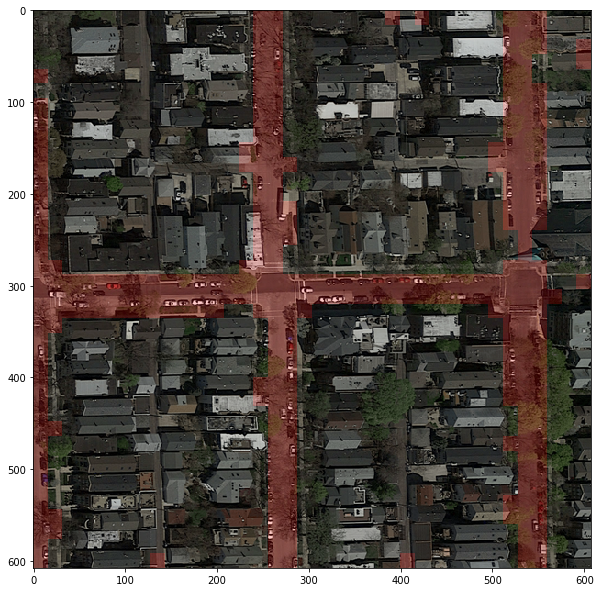

In [128]:
new_img = make_img_overlay(test_images_not_padded[IDX], post_processed_image1)

plt.figure(figsize=[10,20])
plt.imshow(new_img)
plt.savefig('pred.jpg', format='jpg')